In [168]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

def fixedpoint(g, x0, tol=1.e-10, max_iter=30):
    ''' Solve x=g(x) by fixed point iterations
        The output of each iteration is printed
    Input:
        g:   The function g(x)
        x0:  Initial values
        tol: The tolerance
    Output:
        The root and the number of iterations
    '''
    x = x0
    print(f"k ={0:3d}, x = {x:14.10f}") 
    for k in range(max_iter):        
        x_old = x                        # Store old values for error estimation 
        x = g(x)                         # The iteration
        err = abs(x-x_old)               # Error estimate
        if err < tol:                    # The solution is accepted
            print(f"k ={k+1:3d}, x = {x:14.10f}")
            break
    return x, k+1

In [139]:
#parametre
sigma0 = 1000 #kg/m**2 vanns massetetthet
sigma = 500 #kg/m**2 skipets massetetthet
R = 10 #m skipets radius
As = 1/2*np.pi*R**2 #m**2 skipets tverrsnittsareal
m = As*sigma #kg skipets masse
Ic = 1/2*m*R**2*(1-32/(9*np.pi**2)) #skipets treghetsmoment


def sector(beta):
    return np.sin(beta) + np.pi*sigma/sigma0 #the ratio of the ships density to the waters density in (3) is 1/2

beta, steps = fixedpoint(sector, 2.3, max_iter=50)
# vinkelen som beskriver hvor mye av skipet som er i kontakt med vann ved likevekt er beta
# når skipet (er på vei til å) synke(r) er den pi og vi ser at det er beta og ikke beta/2
# fra ligningen for sektorvolumet, blant annet

yM = R*np.cos(beta/2) #Metasenteret til skipet ved likevekt
yC = yM - ((4*R)/(3*np.pi)) #Skipets massesenter ved likevekt
yD = (R*np.cos(beta/2))-R #Skipets dypeste punkt ved likevekt
yB = yM * ((-4*R*np.sin(beta/2))/3*(beta-np.sin(beta))) #Angrepspunktet til oppdriftkraften
print(yM)
print(yC)
print(yD)
print(yB)

k =  0, x =   2.3000000000
k = 49, x =   2.3098814600
4.039727532819079
-0.20440428296479674
-5.960272467180921
-77.39681416333177


In [142]:
def rk4(ti, wi, h_step, f=w_deriv_1):
    k1 = f(ti, wi)
    k2 = f(ti + h_step/2, [wi[0]+h_step/2*k1[0][0], wi[1]+h_step/2*k1[1][0]])
    k3 = f(ti + h_step/2, [wi[0]+h_step/2*k2[0][0], wi[1]+h_step/2*k2[1][0]])
    k4 = f(ti + h_step, [wi[0]+h_step*k3[0][0], wi[1]+h_step*k3[1][0]])
    step = [[h_step/6*(k1[0][0] + 2*k2[0][0] + 2*k3[0][0] +k4[0][0])], [h_step/6*(k1[1][0] + 2*k2[1][0] + 2*k3[1][0] +k4[1][0])]]
    return step

#Implementerer Runge-Kutta Metode som beskrevet i notatet ODE.pdf fra hjemmesiden til TMA4320.
#Denne beregner y_n+1 for metoden

In [143]:
#parametre
sigma0 = 1000 #kg/m**2 vanns massetetthet
sigma = 500 #kg/m**2 skipets massetetthet
R = 10 #m skipets radius
As = 1/2*np.pi*R**2 #m**2 skipets tverrsnittsareal
m = As*sigma #kg skipets masse
IC = 1/2*m*R**2*(1-32/(9*np.pi**2)) # Skipets treghetsmoment
g = 9.81 # Tyngdeakselerasjonen
FG = -m*g # Tyngdekraften
h = 4*R/(3*np.pi) # Avstanden mellom skipets massesenter og metasenteret

def sector(beta):
    return np.sin(beta) + np.pi*sigma/sigma0

beta, steps = fixedpoint(sector, 2.3, max_iter=50)
# vinkelen som beskriver hvor mye av skipet som er i kontakt med vann ved likevekt er beta
# når skipet (er på vei til å) synke(r) er den pi og vi ser at det er beta og ikke beta/2
# fra ligningen for sektorvolumet, blant annet

yM = R*np.cos(beta/2) #m skipets metasenter

k =  0, x =   2.3000000000
k = 49, x =   2.3098814600


In [150]:
def w_deriv_1(t, w): #Dette er f(t, w(t)) fra 1c
    dw = np.array([[w[1]], [FG*h*np.sin(w[0])/IC]]) # Oppdriftskraften er lik minus tyngdekraften i oppgave 1
    return dw

def w_deriv_1_approx(t, w): #Dette er f(t, w(t)) fra 1e
    dw = np.array([[w[1]], [FG*h*w[0]/IC]]) # Bruker small angle approx
    return dw

def euler_method(w0, T_start, T_slutt, h_step, stegfunk = w_deriv_1):
    """
    Beregner utslagsvinkelen theta og vinkelhastigheten omega utfra initialverdiene og til T sekunder

    theta_0: utslagsvinkel ved start
    omega_0: vinkelhastighet ved start
    dt: tidssteg
    """
    dT = T_slutt - T_start
    n = int(dT//h_step)        # Antall steg
    last_step = T_slutt-n*h_step
    w = np.array(([[], []]), dtype = '<f')
    t = np.linspace(T_start, T_slutt-last_step, n + 1)
    t = np.append(t, [float(T_slutt)])
    w = np.concatenate((w, w0), axis = 1)
    for i in range(n+1):           # for-loop over alle verdier f.o.m. 0, til n
        if i == n:
            h_step = last_step
            deriv = h_step*stegfunk(t[i], [w[0][i], w[1][i]])
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1)
            # Passer på at vi alltid avslutter på nøyaktig t = T_slutt
        else:
            deriv = h_step*stegfunk(t[i], [w[0][i], w[1][i]])
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1) # Beregner ett steg med Eulers metode
        
    return w, t

def rk4_method(w0, T_start, T_slutt, h_step, f = w_deriv_1):
    """
    Beregner utslagsvinkelen theta og vinkelhastigheten omega utfra initialverdiene og til T sekunder

    theta_0: utslagsvinkel ved start
    omega_0: vinkelhastighet ved start
    dt: tidssteg
    """
    dT = T_slutt - T_start
    n = int(dT//h_step)        # Antall steg
    last_step = T_slutt-n*h_step
    w = np.array(([[], []]), dtype = '<f')
    t = np.linspace(T_start, T_slutt-last_step, n + 1)
    t = np.append(t, [float(T_slutt)])
    w = np.concatenate((w, w0), axis = 1)
    for i in range(n+1):           # for-loop over alle verdier f.o.m. 0, til n
        if i == n:
            h_step = last_step
            deriv = rk4(t[i], [w[0][i], w[1][i]], h_step, f)
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1)
            # Passer på at vi alltid avslutter på nøyaktig t = T_slutt
        else:
            deriv = rk4(t[i], [w[0][i], w[1][i]], h_step, f)
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1) # Beregner ett steg med RK4 metode
        
    return w, t

0.3490658503988659
Avviket ved 20 grader er: 4.2060e-02 grader.


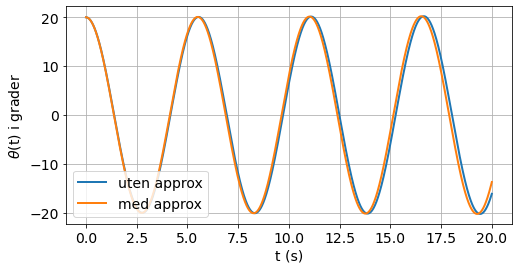

Avviket ved 1 grad er:  5.7613e-06 grader


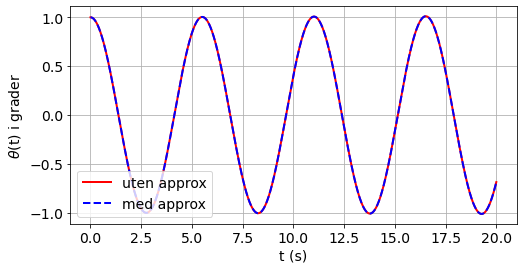

In [151]:
h_step= 0.001

vinkel = 20
w0 = np.array([[vinkel*np.pi/180],[0]])

for a in range(len(w0[0])):
    for b in range(len(w0[0])):
        print(w0[a][b])

w, t = euler_method(w0, 0, 20, h_step)
w_sa, t_sa = euler_method(w0, 0, 20, h_step, stegfunk = w_deriv_1_approx)

plt.plot(t, w[0]*180/np.pi, label = 'uten approx')
plt.plot(t_sa, w_sa[0]*180/np.pi, label = 'med approx')


print(f'Avviket ved 20 grader er: {(w_sa[0][-1]-w[0][-1]):.4e} grader.')

plt.ylabel(r'$\theta$(t) i grader')
plt.xlabel('t (s)')
plt.legend(loc = 3)
plt.show()

vinkel = 1
w0 = np.array([[vinkel*np.pi/180],[0]])


w, t = euler_method(w0, 0, 20, h_step)
w_sa, t_sa = euler_method(w0, 0, 20, h_step, stegfunk = w_deriv_1_approx)



print(f'Avviket ved 1 grad er:  {(w_sa[0][-1]-w[0][-1]):.4e} grader')

plt.plot(t, w[0]*180/np.pi, 'r-', label = 'uten approx')
plt.plot(t_sa, w_sa[0]*180/np.pi, 'b--', label = 'med approx')

plt.ylabel(r'$\theta$(t) i grader')
plt.xlabel('t (s)')
plt.legend(loc = 3)
plt.show()


#plt.plot(t, vinkel*np.cos(np.sqrt(m*g*h/IC)*t), label = 'analytisk approx') #plotter analytisk løsning av lign (10)

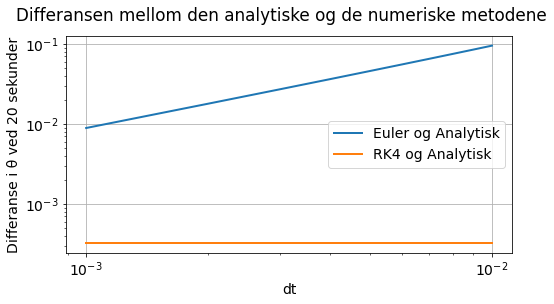

Stigningstallet til differansen mellom Euler og analytisk er -2.1813661987835076e-12
------------------------------------------------------------------------------------
Stigningstallet til differansen mellom RK4 og analytisk er 2.040659863311589e-10


In [187]:
#Oppgave 1h)
h_size = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
diff_e_analytisk = []
analytisk = vinkel*np.cos(np.sqrt(m*g*h/IC)*t[-1])
diff_rk4_analytisk = []

def linfunc(a, b, x):
    return a*x+b

def e_analytisk(a = h_size): #Fyller en liste med differansene mellom Euler og Analytisk
    for i in range(len(a)): #vinkel = 1 er brukt fordi vinkel ikke har så mye å si. Kommenterer her Max...
        w_sa, t_sa = euler_method(w0, 0, 20, a[i], stegfunk = w_deriv_1_approx)
        diff_e_analytisk.append(abs(w_sa[0][-1]*(180/np.pi) - analytisk)) 

def rk4_analytisk(a = h_size): #Fyller en liste differansene mellom RK4 og Analytisk
    for i in range(len(a)):
        w_rk, t_rk = rk4_method(w0, 0, 20, a[i])
        diff_rk4_analytisk.append(abs(w_rk[0][-1]*(180/np.pi)-analytisk))

e_analytisk()
rk4_analytisk()

popt, pcov = curve_fit(linfunc, np.log10(diff_e_analytisk), np.log10(diff_e_analytisk))
popt2, pcov2 = curve_fit(linfunc, np.log10(diff_rk4_analytisk), np.log10(diff_rk4_analytisk))
e_stig = popt[0] #Finner stigningstallet til differansen mellom analytisk og Euler
rk4_stig = popt2[0] #Finner stigningstallet til differansen mellom analytisk og RK4

plt.plot(h_size, diff_e_analytisk, label = 'Euler og Analytisk')
plt.plot(h_size, diff_rk4_analytisk, label = 'RK4 og Analytisk')
plt.ylabel('Differanse i θ ved 20 sekunder')
plt.xlabel('dt')
plt.suptitle('Differansen mellom den analytiske og de numeriske metodene')
plt.legend(loc = 5)
plt.yscale("log")
plt.xscale("log")
plt.show()

print(f'Stigningstallet til differansen mellom Euler og analytisk er {e_stig}')
print('------------------------------------------------------------------------------------')
print(f'Stigningstallet til differansen mellom RK4 og analytisk er {rk4_stig}')

Steglengdene som brukes ved begge metodene er i intervallet [0.001, 0.01]. Utifra plottet så er det mulig å se at feilen øker når steglengden i intervallet øker, noe som er forventet. 